# Guided Project: Analyzing NYC High School Data

## Table of Contents

1. [Introduction](#introduction)
2. [Read in the data](#read-in-the-data)
3. [Read in the surveys](#read-in-the-surveys)
4. [Add DBN columns](#add-dbn-columns)
5. [Convert columns to numeric](#convert-columns-to-numeric)
6. [Condense datasets](#condense-datasets)
7. [Convert AP scores to numeric](#convert-ap-scores-to-numeric)
8. [Combine the datasets](#combine-the-datasets)
9. [Add a school district column for mapping](#add-a-school-district-column-for-mapping)
10. [Find correlations](#find-correlations)
11. [Plotting survey correlations](#plotting-survey-correlations)
12. [Exploring Safety and SAT Scores](#exploring-safety-and-sat-scores)
13. [Exploring Race and SAT Scores](#exploring-race-and-sat-scores)
14. [Exploring Gender and SAT Scores](#exploring-gender-and-sat-scores)
15. [Exploring AP Scores vs. SAT Scores](#exploring-ap-scores-vs-sat-scores)
16. [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>
This is a guided project I completed on the [Dataquest](https://app.dataquest.io)  learning platform. 
The focus of this project was to learn new skills related to the data cleansing workflow. The goals are to cleanse and merge the available public data sets as well as to start investigating any correlations between the SAT Scores and other factors apparent from New York City public schools.
The code is written in Python, using pandas, numpy and re libraries, and is shown in Jupyter Notebooks.

The public data sets used are available from the following sources:
-  [student SAT scores](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) by high school
- [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) - Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated and other outcome information
- [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
- [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

The conclusion of the observations is at the end of this notebook. 

Note: there may be some PerformanceWarnings appearring after some code. The performance impact is however not noticeable.

# Read in the data <a name="read-in-the-data"></a>

In [196]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("data/schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys <a name="read-in-the-surveys">

In [197]:
all_survey = pd.read_csv("data/schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("data/schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
# combine the two dataframes, prior to defragmenting 
survey_pre_defragment = pd.concat([all_survey, d75_survey], axis=0)
# defragment the dataframe using copy() (otherwise we get an "educational" Performance Warning from pandas)
survey = survey_pre_defragment.copy()

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns <a name="add-dbn-columns">

In [198]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric  <a name="convert-columns-to-numeric">

In [199]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets <a name="condense-datasets">

In [200]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

#  works on pandas 3 by adding numeric_only=True
class_size = class_size.groupby("DBN").mean(numeric_only=True)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric <a name="convert-ap-scores-to-numeric">

In [201]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets <a name="combine-the-datasets">

In [202]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = [
            "class_size", 
            "demographics", 
            "survey", 
            "hs_directory"
            ]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean(numeric_only=True))
combined = combined.fillna(0)

# Add a school district column for mapping <a name="add-a-school-district-column-for-mapping">

In [203]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)



/tmp/ipykernel_131056/1501977650.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)


# Find correlations <a name="find-correlations">

In [204]:
correlations = combined.corr(numeric_only=True)
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations <a name="plotting-survey-correlations">

In [205]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")



# Exploring Safety and SAT Scores <a name="exploring-safety-and-sat-scores">

## Investigate safety scores 

<Axes: xlabel='sat_score', ylabel='saf_s_11'>

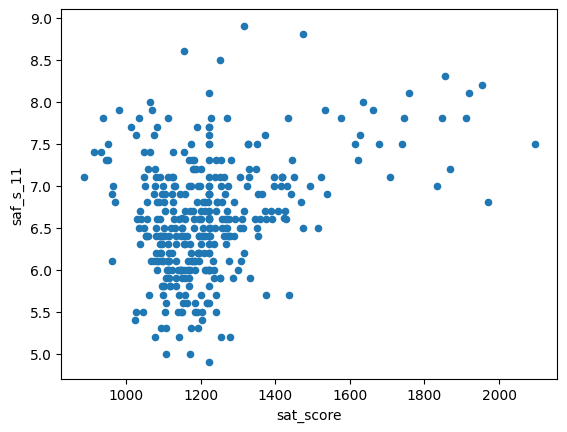

In [206]:
# Make a scatter plot of the saf_s_11 column vs. the sat_score in combined. 
combined.plot(kind="scatter", x="sat_score", y="saf_s_11")

### Observation about Safety
There seems to be a strong positive correlation between Safety and SAT Scores. 

## Compute safety scores

In [207]:
# Compute the average safety score for each borough.
boro_saft_avg = combined.groupby("boro")["saf_s_11"].mean()
print(boro_saft_avg)

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


### Observation about Safety Scores
The schools in the borough of Brooklyn scores the lowest average safety score, while the schools in the borough of Manhattan scores the highest average safety scores.

# Exploring Race and SAT Scores <a name="exploring-race-and-sat-scores">

## Investigate racial differences in SAT scores

<Axes: >

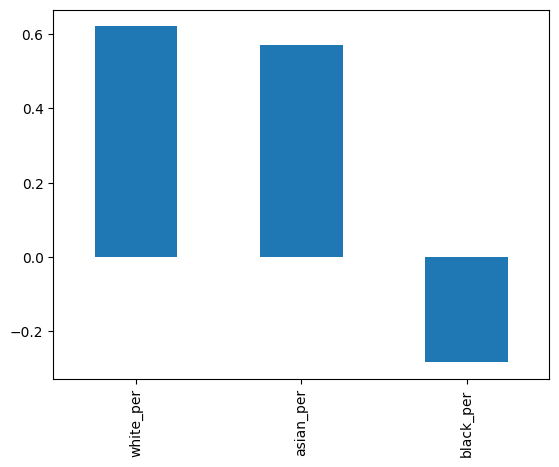

In [208]:
# a bar plot of the correlations between the race percentage and sat_score
race_scor_cols = ["white_per", "asian_per", "black_per"]
combined.corr(numeric_only=True)["sat_score"][race_scor_cols].plot.bar()


### Observation about correlation of racial differences and SAT scores
For the correlation between the race of the students and the SAT scores, there appears to be rather strong positive correlations for white and asian. For black, there is a weak negative correlation.

## Explore schools with low SAT scores and high values for hispanic_per

<Axes: xlabel='sat_score', ylabel='hispanic_per'>

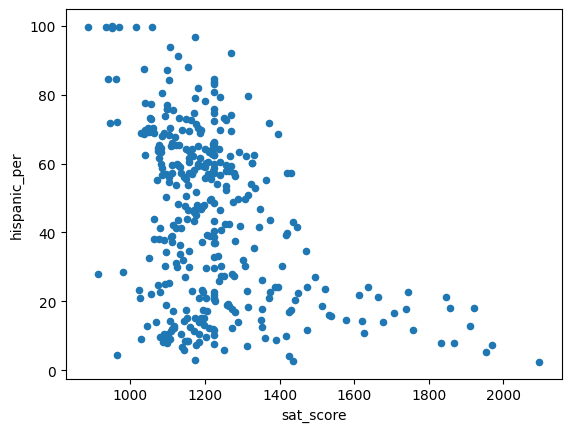

In [209]:
# Make a scatter plot of the hispanic_per vs. the sat_score in combined. 
combined.plot(kind="scatter", x="sat_score", y="hispanic_per")

### Observation of scatter plot: hispanic percentage vs. SAT scores
When the SAT Scores are above around 1500, there appears to be strong negative correlation with hispanic attendees. To confirm, create a scatterplot with SAT scores only above 1500 to check this observation. 

The r-value for the correlation between sat_score and hispanic_per is:


-0.6171859644178845

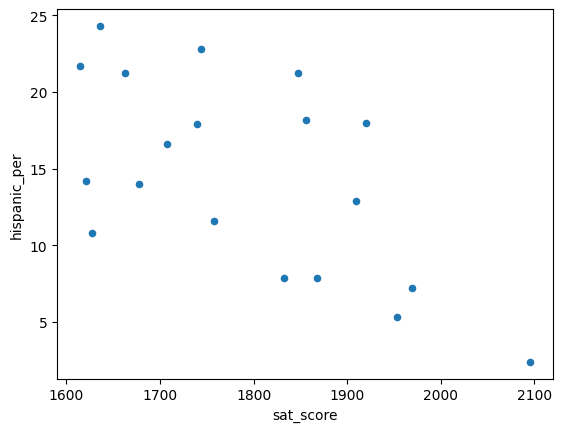

In [210]:
# limit to scores above 1500 and create a new scatterplot
combined_gt_1500 = combined[combined["sat_score"]>1600]
combined_gt_1500.plot(kind="scatter", x="sat_score", y="hispanic_per")
print("The r-value for the correlation between sat_score and hispanic_per is:")
combined_gt_1500.corr(numeric_only=True)["sat_score"]["hispanic_per"]

## Research any schools with a hispanic_per greater than 95%

In [211]:
# filter the data for >95%
combined_hisp_gt_95 = combined[combined["hispanic_per"] > 95]
print(combined_hisp_gt_95["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


### Observations about these schools
These schools seem to be aimed towards Spanish-speaking students from Latin American backgrounds.
Also, the schools are not consistently represented on Wikipedia. 

## Research any schools with a hispanic_per less than 10% and an average SAT score greater than 1800

In [212]:
combined_hisp_lt_10 = combined[combined["hispanic_per"] < 10]
combined_hisp_lt_10_ss_gt_1800 = combined_hisp_lt_10[combined_hisp_lt_10["sat_score"] > 1800]
print(combined_hisp_lt_10_ss_gt_1800["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


### Observations about these schools
These schools seem to be high in demand, with only about 3% of applications accepted. This indicates that they are on average accepting less than 10% Hispanic students, and on average accepting students with SAT scores higher than 1800.
Also, the schools are consistently represented on Wikipedia. 

# Exploring Gender and SAT Scores <a name="exploring-gender-and-sat-scores">

## Investigate gender differences in SAT scores.

<Axes: >

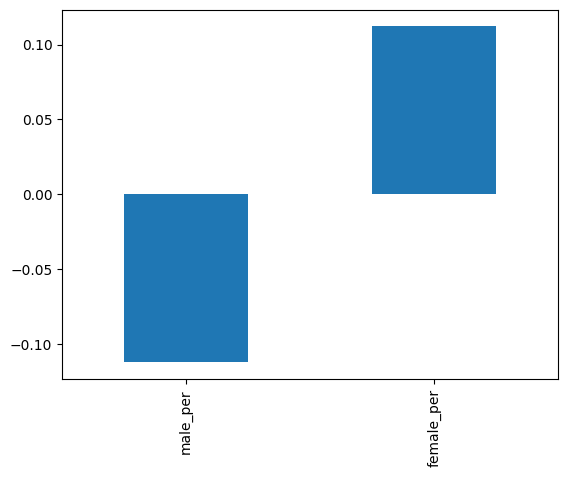

In [213]:
# a bar plot of the correlations between the gender and sat_score
gender_scor_cols = ["male_per", "female_per"]
combined.corr(numeric_only=True)["sat_score"][gender_scor_cols].plot.bar()

### Observations about the genders
It appears like there are weak postive and negative correlations with SAT scores for male and female student percentages, respectively.

#  Exploring AP Scores vs. SAT Scores <a name="exploring-ap-scores-vs-sat-scores">

## Percentage students in each school taking an AP exam
Correlate this AP percentage with the SAT Score.

<Axes: xlabel='sat_score', ylabel='ap_per'>

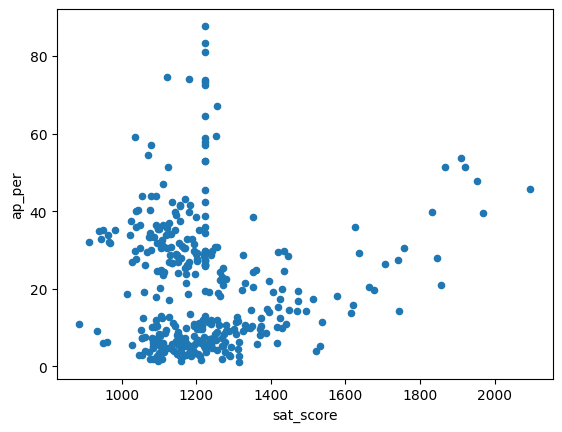

In [216]:
#
# calculate the ap_per and add as a new column to the dataset
combined["ap_per"] = (combined["AP Test Takers "] / combined["total_enrollment"])*100
# draw a scatter plot
combined.plot(kind="scatter", x="sat_score", y="ap_per")

### Observations about the relationship between AP scores and SAT scores
From the chart above it appears that there is no observable relationship between AP Scores and SAT Scores over the whole dataset. However, there is a quite strong positive correlation when looking only at those who scored above 1300 for the SAT Score. See the enhanced scatter plot below.  
Also, from the chart above, what is interesting, is there is a almost perfect vertical linear relationship with AP scores where the SAT Score is just above 1200. This could indicate that there is a requirement to take the AP Test if the SAT score is equal to a certain number around 1200.

The r-value for the correlation between sat_score > 1300 and ap_per is:


0.7244882289593129

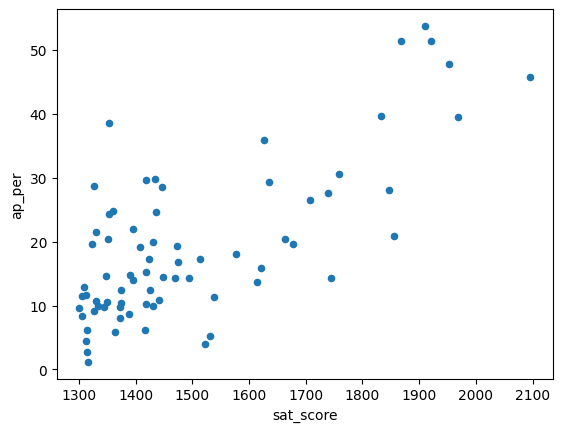

In [215]:
# limit to scores above 1300 and create a new scatterplot
combined_gt_1300 = combined[combined["sat_score"]>1300]
combined_gt_1300.plot(kind="scatter", x="sat_score", y="ap_per")
print("The r-value for the correlation between sat_score > 1300 and ap_per is:")
combined_gt_1300.corr(numeric_only=True)["sat_score"]["ap_per"]

## Conclusion <a name="conclusion">

In conclusion, the observations regarding NYC Schools' SAT scores reveal several key insights. 

First, safety within schools exhibits a strong positive correlation with SAT scores. Schools in Manhattan have the highest average safety scores, while those in Brooklyn have the lowest. 

Regarding racial differences, there are notable correlations with SAT scores. Positive correlations are observed for white and Asian students, while a weak negative correlation is seen for black students. A significant negative correlation between Hispanic percentage and SAT scores is apparent for scores above 1500.

Schools with a Hispanic percentage above 95% are likely designed for Spanish-speaking students from Latin American backgrounds, but lack consistent representation on Wikipedia. Conversely, schools with a Hispanic percentage below 10% and average SAT scores exceeding 1800 are in high demand, with limited acceptance rates and consistent Wikipedia representation.

Gender-wise, weak positive and negative correlations with SAT scores are noted for male and female students, respectively. In terms of AP scores' relationship with SAT scores, the overall dataset shows no observable correlation. However, a strong positive correlation becomes evident when focusing solely on SAT scores above 1300. Notably, a near-vertical linear relationship between AP and SAT scores exists around an SAT score of just above 1200, hinting at a possible AP test requirement for certain SAT score thresholds.